In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
import math
from utils import *
%matplotlib inline

# RH strategy

In [7]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.buy_executed = None
        
        self.gaps_up = self.data.open > self.data.close(-1)
        self.higher_high = self.data.high > self.data.high(-1)
        self.closes_below = self.data.close < self.data.open
        self.positive_on_the_day = self.data.close > self.data.close(-1)
        self.close_200 = self.data.close > bt.indicators.SimpleMovingAverage(self.data, period=200)
        
        self.conditions = bt.And(self.gaps_up, self.higher_high, self.closes_below, self.positive_on_the_day, self.close_200)
        self.all_conditions = bt.And(self.conditions, self.conditions(-1))

    def next(self):
        if self.buy_executed and len(self) >= (self.buy_executed + 5):
            self.log('SELL')
            self.sell(exectype=bt.Order.Market)
            self.buy_executed = None
        elif self.all_conditions[0] and not math.isnan(self.all_conditions[0]):
            self.log('BUY')
            self.buy(exectype=bt.Order.Market)
            self.buy_executed = len(self)
#             self.log_candles()

In [8]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

# data = bt.feeds.YahooFinanceData(
#     dataname='SPY',
#     fromdate=datetime(2004,1,1),
#     todate=datetime(2018,1,1),
#     reverse=False, 
#     adjclose=False)

data = bt.feeds.PandasData(dataname=read_ami_SPY_data())

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=10)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2000-07-13, BUY
2000-07-14, BUY EXECUTED, 149.78
2000-07-20, SELL
2000-07-21, SELL EXECUTED, 150.62
2004-05-24, BUY
2004-05-25, BUY EXECUTED, 110.27
2004-06-01, SELL
2004-06-02, SELL EXECUTED, 112.71
2004-11-02, BUY
2004-11-03, BUY EXECUTED, 113.55
2004-11-09, SELL
2004-11-10, SELL EXECUTED, 116.88
2005-01-26, BUY
2005-01-27, BUY EXECUTED, 117.23
2005-02-02, SELL
2005-02-03, SELL EXECUTED, 119.27
2006-01-25, BUY
2006-01-26, BUY EXECUTED, 126.66
2006-02-01, SELL
2006-02-02, SELL EXECUTED, 128.39
2007-03-30, BUY
2007-04-02, BUY EXECUTED, 142.00
2007-04-09, SELL
2007-04-10, SELL EXECUTED, 144.44
2010-03-03, BUY
2010-03-04, BUY EXECUTED, 112.30
2010-03-10, SELL
2010-03-11, SELL EXECUTED, 114.97
2010-12-14, BUY
2010-12-15, BUY EXECUTED, 124.67
2010-12-21, SELL
2010-12-22, SELL EXECUTED, 125.39
2010-12-29, BUY
2010-12-30, BUY EXECUTED, 125.92
2011-01-05, SELL
2011-01-06, SELL EXECUTED, 127.64
2012-02-21, BUY
2012-02-22, BUY EXECUTED, 136.46
2012-02-28, SEL

In [9]:
len(transactions)

32

In [10]:
# def prev_weekday(adate):
#     adate -= timedelta(days=1)
#     while adate.weekday() > 4: # Mon-Fri are 0-4
#         adate -= timedelta(days=1)
#     return adate.date()

# temp_trans = transactions.copy()
# temp_trans.index = temp_trans.index.map(lambda v: prev_weekday(v))
# temp_trans

transactions

,amount,price,sid,symbol,value
date,,,,,
2000-07-14 00:00:00+00:00,66.764053,149.7812,0,,-10000.000000
2000-07-21 00:00:00+00:00,-66.764053,150.6250,0,,10056.335508
2004-05-25 00:00:00+00:00,90.719397,110.2700,0,,-10003.627917
2004-06-02 00:00:00+00:00,-90.719397,112.7100,0,,10224.983246
2004-11-03 00:00:00+00:00,88.276007,113.5500,0,,-10023.740589
2004-11-10 00:00:00+00:00,-88.276007,116.8800,0,,10317.699692
2005-01-27 00:00:00+00:00,85.738312,117.2300,0,,-10051.102355
2005-02-03 00:00:00+00:00,-85.738312,119.2700,0,,10226.008512
2006-01-26 00:00:00+00:00,79.477067,126.6600,0,,-10066.565260


Entire data start date: 2002-03-01
Entire data end date: 2018-01-18
Backtest months: 190


C:\DEV\Anaconda3\envs\trading\lib\site-packages\empyrical\stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,0.1%
Cumulative returns,1.3%
Annual volatility,0.1%
Sharpe ratio,0.69
Calmar ratio,0.28
Stability,0.68
Max drawdown,-0.3%
Omega ratio,2.35
Sortino ratio,1.46
Skew,7.73


C:\DEV\Anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.29,2012-02-28,2017-08-03,NaT,NaN
1,0.08,2006-01-27,2006-01-31,2007-04-03,308
2,0.07,2010-03-10,2010-12-15,2010-12-21,205
3,0.05,2011-01-05,2012-02-22,2012-02-24,298
4,0.05,2004-11-05,2004-11-10,2005-01-31,62


C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\plotting.py:819: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


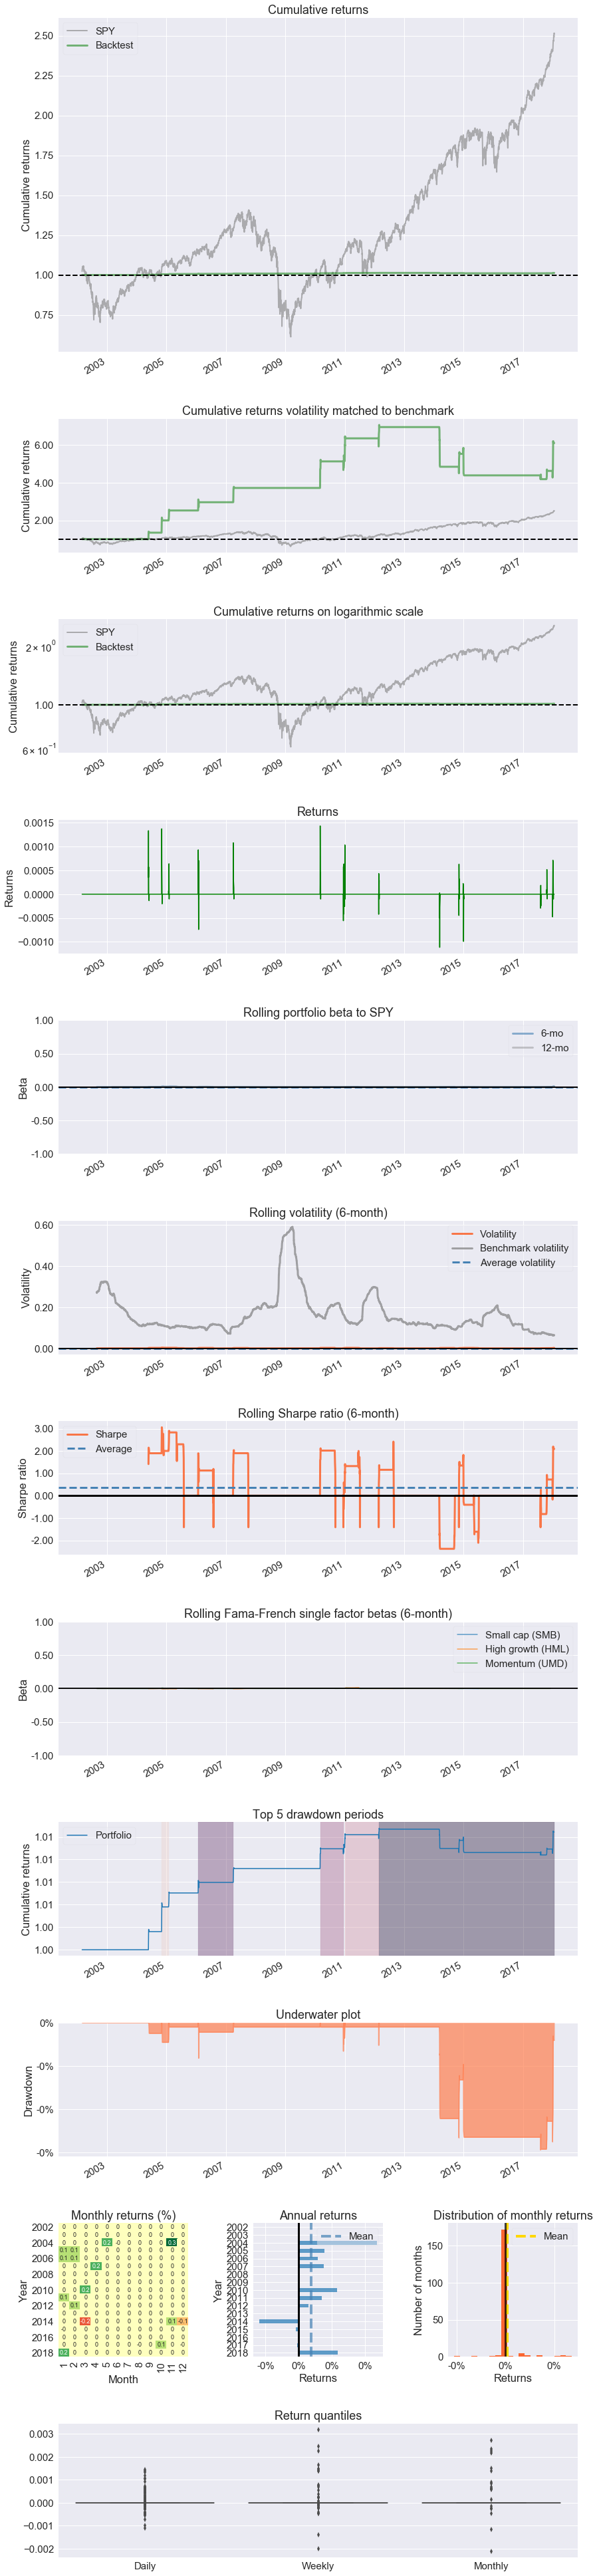

Stress Events,mean,min,max
Dotcom,0.00%,-0.08%,0.14%
Lehmann,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,0.00%,0.00%,0.00%
Aug07,0.00%,0.00%,0.00%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


KeyError: 'Dotcom'

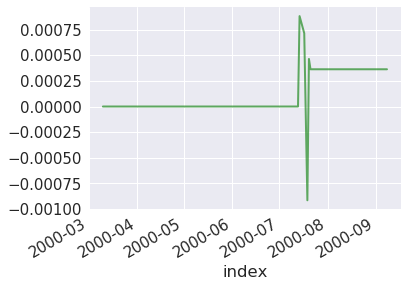

In [11]:
pf.create_full_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions,
                          round_trips=True)